# Ejercicio de clasificación

Realizar estudios  de aprendizaje utilizando random forests. El enunciado del ejercicio es el siguiente:

**Enunciado.** https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction. Clasificación binaria. El objetivo es clasificar entre presencia de enfermedad del corazón o no a partir de una serie de atributos (edad, sexo, colesterol, etc.). Para ello el dataset contiene una serie de datos pacientes etiquetados si tienen enfermedad o no.

**_Importación de librerías necesarias_**

In [1]:
from google.colab import drive
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split, cross_val_score, KFold

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

**_Preproceso_**

*Importación de los datos del datasets*

In [2]:
drive.mount("/content/drive")

df_cardio = pd.read_csv("/content/drive/My Drive/IABD/SAA/datasets/Tema 2/cardio.csv")

Mounted at /content/drive


*Mostrar las primera y últimas filas del data frame importado*

In [3]:
df_cardio
# Colab muestra las primeras y últimas filas, si se hace desde un entorno de ejecución diferente que no se jupiter se haría de la siguiente forma:
# df_cardio.head()
# df_cardio.tail()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


## Estudio de los atributos del dataframe:

Tipos de valores que tiene el dataset.

In [4]:
df_cardio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


### Age (Edad)
Los valores se encuentran entre 28 y 77. En un principio no se encuentran outliers.

In [5]:
df_cardio['Age'].describe()

,Age
count,918.000000
mean,53.510893
std,9.432617
min,28.000000
25%,47.000000
50%,54.000000
75%,60.000000
max,77.000000


## Sex (Sexo)
Valores:
- M: Male (Hombre)
- F: Female (Mujer)

En un principio podemos observar que tiene dos valores (M, F) y el que mayor frecuencia tiene es la M con un total de 725 mientras que la F tiene 193 ocurrencias.

In [6]:
df_cardio['Sex'].describe()

,Sex
count,918
unique,2
top,M
freq,725


In [7]:
df_cardio.groupby(["Sex"]).size() # size: Develve el total de ocurrencias que tiene cada uno de los valores.

,0
Sex,
F,193
M,725


## ChestPainType (Tipo de dolor en el pecho)
Este atributo tiene 4 valores diferentes y el que más se repite es ASY con un total de 496 veces.
Con el groupby observamos que los valores que puede tomar son:
- ASY (496): asintomatico (sin sintomas evidentes).
- ATA (173): angina atípica, dolor en el pecho no atípico de una angina de pecho clásica.
- NAP (203): dolor no anginioso, dolor en el pecho que no está relacionado con la angina de pecho.
- TA (46): tensión arterial.

In [8]:
df_cardio['ChestPainType'].describe()

,ChestPainType
count,918
unique,4
top,ASY
freq,496


In [9]:
df_cardio.groupby(['ChestPainType']).size()

,0
ChestPainType,
ASY,496
ATA,173
NAP,203
TA,46


## Mapa de calor

Antes de continuar con la transformación de los datos, vamos a ver que nos indica el mapa de calor para ver si alguna de las características es prencindible. Para ello realizo una copia del dataset original y transformo los atributos con valores categóricos. No existen relaciones muy marcadas entre el resto de características y la objetivo (HeartDisease), ya que, se encuentran entre los valores -0.56 y 0.49 (ninguna se hacerca demasiado al 1 o -1). Mientras que la característica que más se acerca a 0 es RenstingECG. Otras características que se podrían prescindir de ellas serían las que se encuentran entre los valores 0.3 y -0.3, pero para saberlo se verá cuando se realice el modelo.

In [10]:
le = preprocessing.LabelEncoder()
df_cardio_copia = df_cardio.copy()
df_cardio_copia["Sex"] = le.fit_transform(df_cardio_copia.Sex.values)
df_cardio_copia["ChestPainType"] = le.fit_transform(df_cardio_copia.ChestPainType.values)
df_cardio_copia["RestingECG"] = le.fit_transform(df_cardio_copia.RestingECG.values)
df_cardio_copia["ExerciseAngina"] = le.fit_transform(df_cardio_copia.ExerciseAngina.values)
df_cardio_copia["ST_Slope"] = le.fit_transform(df_cardio_copia.ST_Slope.values)

In [11]:
df_cardio_copia.describe()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,0.789760,0.781046,132.396514,198.799564,0.233115,0.989107,136.809368,0.404139,0.887364,1.361656,0.553377
std,9.432617,0.407701,0.956519,18.514154,109.384145,0.423046,0.631671,25.460334,0.490992,1.066570,0.607056,0.497414
min,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000
25%,47.000000,1.000000,0.000000,120.000000,173.250000,0.000000,1.000000,120.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,0.000000,130.000000,223.000000,0.000000,1.000000,138.000000,0.000000,0.600000,1.000000,1.000000
75%,60.000000,1.000000,2.000000,140.000000,267.000000,0.000000,1.000000,156.000000,1.000000,1.500000,2.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,1.000000


<Axes: >

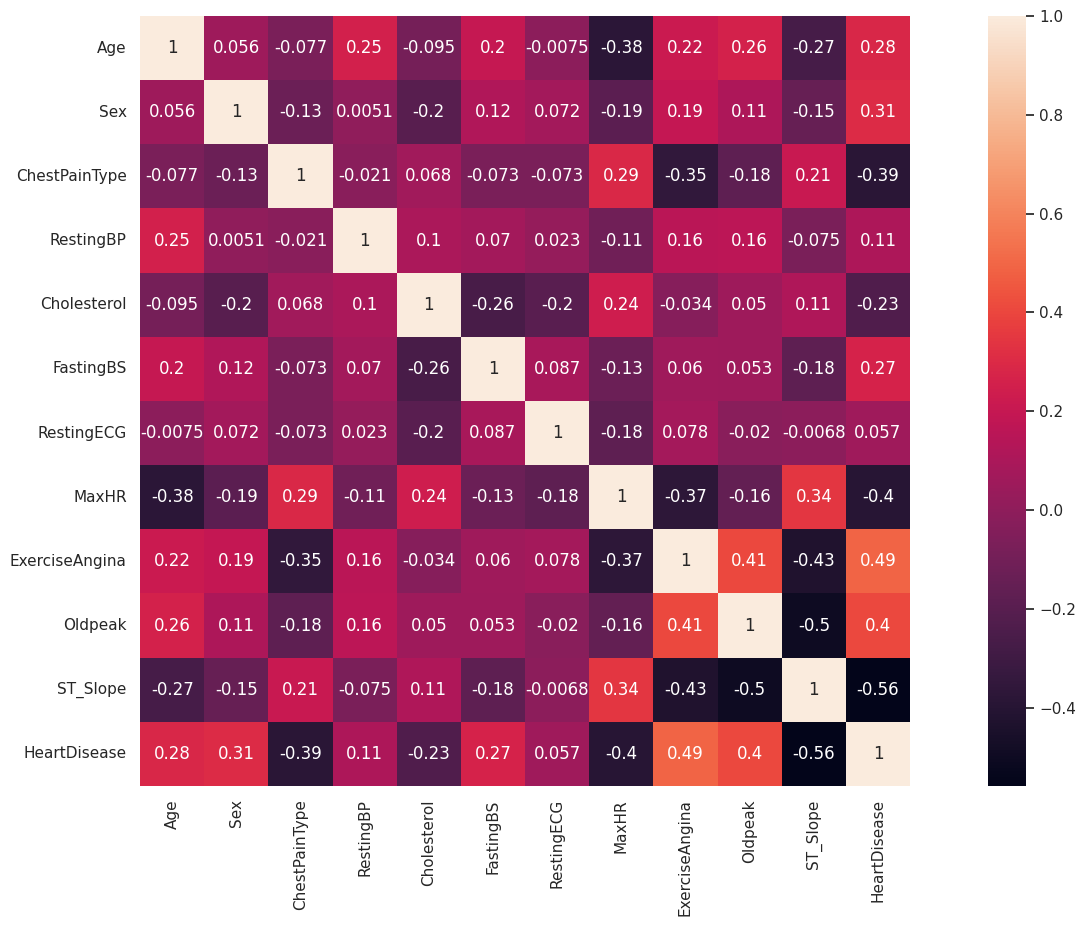

In [12]:
sns.set(rc={"figure.figsize": (20, 10)})
sns.heatmap(df_cardio_copia.corr(), square = True, annot = True)

## Transformación de los atributos

Para la transformación se va a utilizar get_dumies, es una función que trae pandas. Esta te tranforma los atributos categoricos en booleanos.

In [13]:
data_norm = pd.get_dummies(df_cardio)
data_norm

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,False,True,False,...,False,False,False,True,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,True,False,False,...,True,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,False,True,False,...,False,False,False,False,True,True,False,False,False,True
3,48,138,214,0,108,1.5,1,True,False,True,...,False,False,False,True,False,False,True,False,True,False
4,54,150,195,0,122,0.0,0,False,True,False,...,True,False,False,True,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,0,132,1.2,1,False,True,False,...,False,True,False,True,False,True,False,False,True,False
914,68,144,193,1,141,3.4,1,False,True,True,...,False,False,False,True,False,True,False,False,True,False
915,57,130,131,0,115,1.2,1,False,True,True,...,False,False,False,True,False,False,True,False,True,False
916,57,130,236,0,174,0.0,1,True,False,False,...,False,False,True,False,False,True,False,False,True,False


In [14]:
def detectarLimitesOutlier(df: pd.DataFrame, k: int = 3):
  Q1 = df.quantile(0.25)
  Q3 = df.quantile(0.75)
  IQR = Q3 - Q1
  xL = Q1 - k * IQR # Límite inferior
  xU = Q3 + k * IQR # Límite Superior
  return (xL, xU)

def outliersCambiarMedia(df: pd.DataFrame, k = 3) -> pd.DataFrame:
    df_numeric = df.select_dtypes(include=[np.number])

    xL, xU = detectarLimitesOutlier(df_numeric, k)

    outliers = (df_numeric < xL) | (df_numeric > xU)

    df_sin_outliers = df.copy()

    for columna in df_numeric.columns:
        media = df_numeric[columna].mean()
        if df_sin_outliers[columna].dtype == 'int64':
          df_sin_outliers.loc[outliers[columna], columna] = int(media)
        else:
          df_sin_outliers.loc[outliers[columna], columna] = media

    return df_sin_outliers

In [15]:
data_norm = outliersCambiarMedia(data_norm)
data_norm

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,False,True,False,...,False,False,False,True,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,True,False,False,...,True,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,False,True,False,...,False,False,False,False,True,True,False,False,False,True
3,48,138,214,0,108,1.5,1,True,False,True,...,False,False,False,True,False,False,True,False,True,False
4,54,150,195,0,122,0.0,0,False,True,False,...,True,False,False,True,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,0,132,1.2,1,False,True,False,...,False,True,False,True,False,True,False,False,True,False
914,68,144,193,0,141,3.4,1,False,True,True,...,False,False,False,True,False,True,False,False,True,False
915,57,130,131,0,115,1.2,1,False,True,True,...,False,False,False,True,False,False,True,False,True,False
916,57,130,236,0,174,0.0,1,True,False,False,...,False,False,True,False,False,True,False,False,True,False


El siguiente paso es normalizar los datos de las características numericas. Primero eliminaré las columnas que no nos interesa para el entrenamiento. Luego obtengo todos los atributos que sean de tipo numérico y los añado añado a una nueva variable. Elimino de esta nueva variable la caracteristica obtetivo. Para finalizar escalo los datos de las columnas anteriores y se los añado al dataset principal.

In [16]:
data_norm = data_norm.drop("RestingBP", axis=1)
data_norm_num = data_norm.select_dtypes(include=[np.number])
scaler = preprocessing.MinMaxScaler()

data_norm_num = data_norm_num.drop(columns=["HeartDisease"], axis=1)

data_norm[data_norm_num.columns] = scaler.fit_transform(data_norm_num)

data_norm


,Age,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,0.244898,0.546314,0.0,0.788732,0.317073,0,False,True,False,True,False,False,False,True,False,True,False,False,False,True
1,0.428571,0.340265,0.0,0.676056,0.439024,1,True,False,False,False,True,False,False,True,False,True,False,False,True,False
2,0.183673,0.534972,0.0,0.267606,0.317073,0,False,True,False,True,False,False,False,False,True,True,False,False,False,True
3,0.408163,0.404537,0.0,0.338028,0.500000,1,True,False,True,False,False,False,False,True,False,False,True,False,True,False
4,0.530612,0.368620,0.0,0.436620,0.317073,0,False,True,False,False,True,False,False,True,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,0.346939,0.499055,0.0,0.507042,0.463415,1,False,True,False,False,False,True,False,True,False,True,False,False,True,False
914,0.816327,0.364839,0.0,0.570423,0.731707,1,False,True,True,False,False,False,False,True,False,True,False,False,True,False
915,0.591837,0.247637,0.0,0.387324,0.463415,1,False,True,True,False,False,False,False,True,False,False,True,False,True,False
916,0.591837,0.446125,0.0,0.802817,0.317073,1,True,False,False,True,False,False,True,False,False,True,False,False,True,False


Separo el resto de características de la objetivo.

In [31]:
x_df_cardio = data_norm.drop(["HeartDisease"], axis=1)

y_df_cardio = data_norm['HeartDisease']

Separo los datos entre entrenamiento y prueba (usando un 80% para entrenamiento y 20% test)

In [18]:
x_entrenamiento, x_test, y_entrenamiento, y_test = train_test_split(x_df_cardio, y_df_cardio, random_state=1, test_size=0.2)

**_Entrenamiento y predicción_**

_Elegir, instanciar (eligiendo unos valores concretos, por ejemplo profundidad del árbol 3) y entrenar el modelo_

In [19]:
modelo = RandomForestClassifier(n_estimators = 100, random_state=1)
modelo.fit(x_entrenamiento, y_entrenamiento)

RandomForestClassifier(random_state=1)

*Realizar una predicción con los datos de prueba*

In [20]:
y_prediccion = modelo.predict(x_test)

**_Evaluación_**

*Mostrar el porcentaje de elementos correctamente clasificados*

In [21]:
print("La probabilidad de acertar es: ", accuracy_score(y_test, y_prediccion))

La probabilidad de acertar es:  0.8804347826086957


*Mostrar la predicción realiza (imprimir la variable con la predicción)*

In [22]:
print(y_prediccion)

[1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0 1 0 1 0 1 1 0 1 1 0 0 0 0 0 1 1 1
 1 0 0 1 1 1 0 0 0 1 0 0 1 0 1 1 0 0 0 1 0 1 0 1 1 1 0 0 1 1 1 0 1 1 0 1 1
 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 0 0
 1 0 0 0 0 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1
 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0 0 1]


*Representar gráficamente la clasificación obtenida (matríz de confusión).*

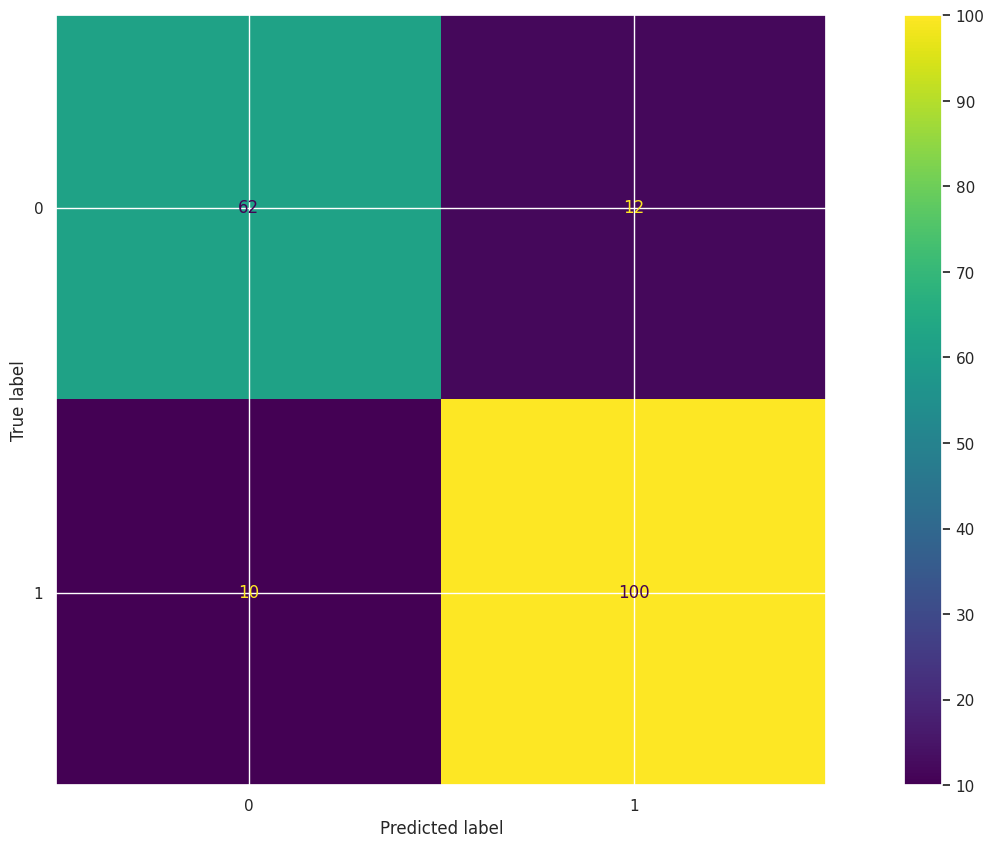

In [23]:
ConfusionMatrixDisplay.from_predictions(y_test, y_prediccion)

#### Curva ROC
Gráfico que muestra el rendimiento de un modelo de clasificación al variar el umbral de decisión. En lugar de elegir un umbral fijo (por ejemplo, 0.5), evalúa cómo cambian las tasas de verdaderos positivos y falsos positivos con diferentes umbrales.

#### El AUC
Es el Área Bajo la Curva ROC. Es un valor numérico que mide el desempeño del modelo.
- Interpretación:
  - AUC = 1.0: Clasicicación perfecta.
  - AUC = 0.5: Clasificador aleatorio (sin capacidad predictiva).
  - AUC < 0.5:Rendimiento peor que un clasificador aleatorio (esto indica que el modelo está prediciendo al revés, lo cuál generalmente significa que hay un problema en el entrenamiento o los datos).

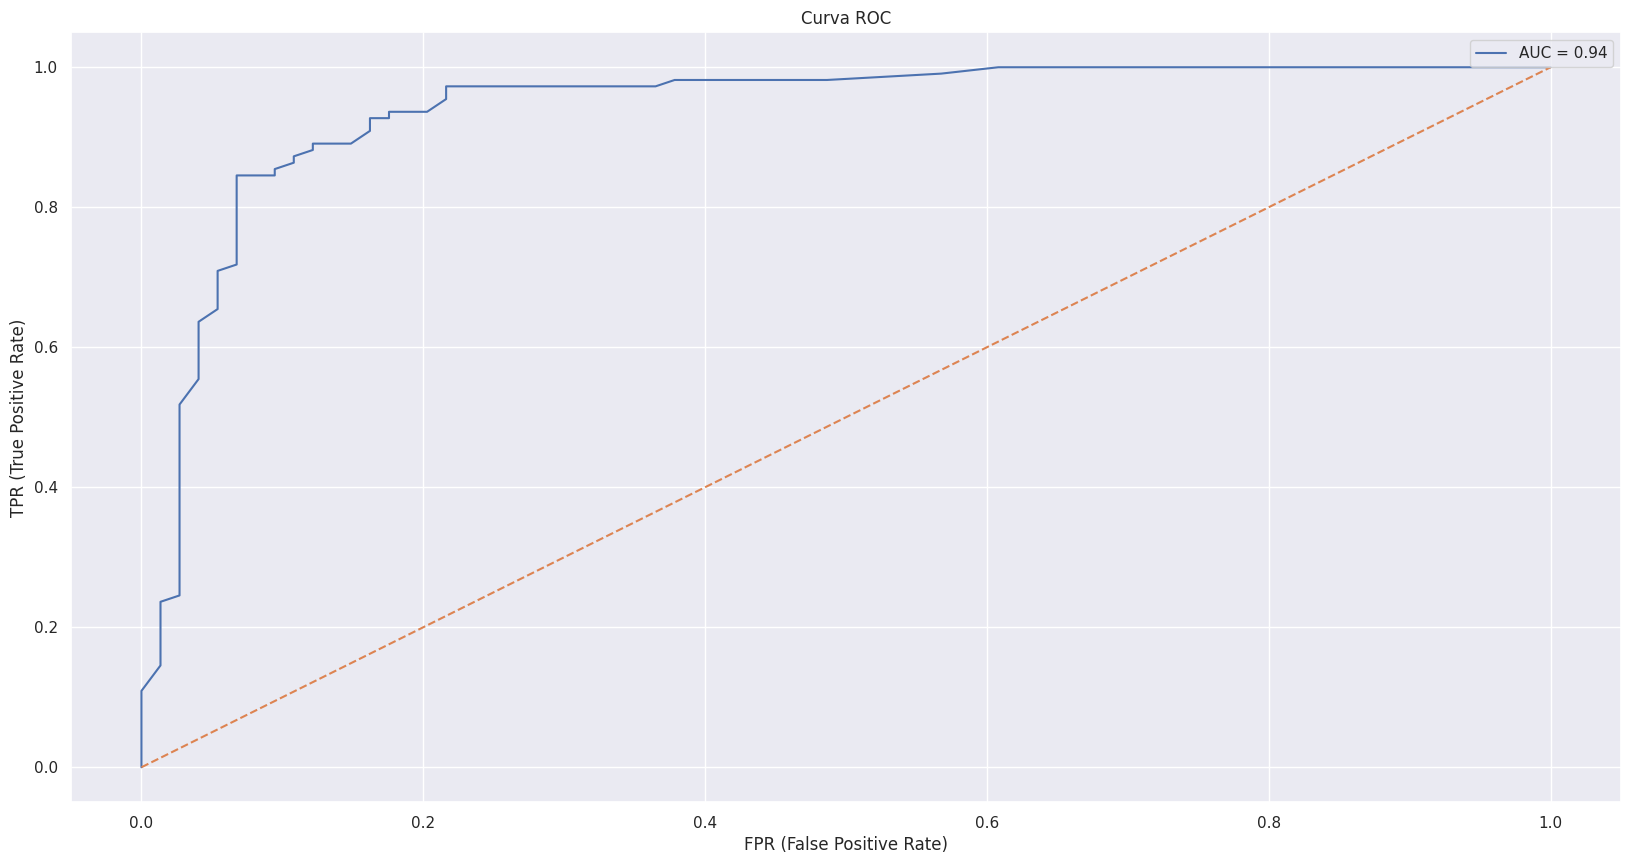

In [24]:
y_prob = modelo.predict_proba(x_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.title("Curva ROC")
plt.legend()
plt.show()

Importancia de las características

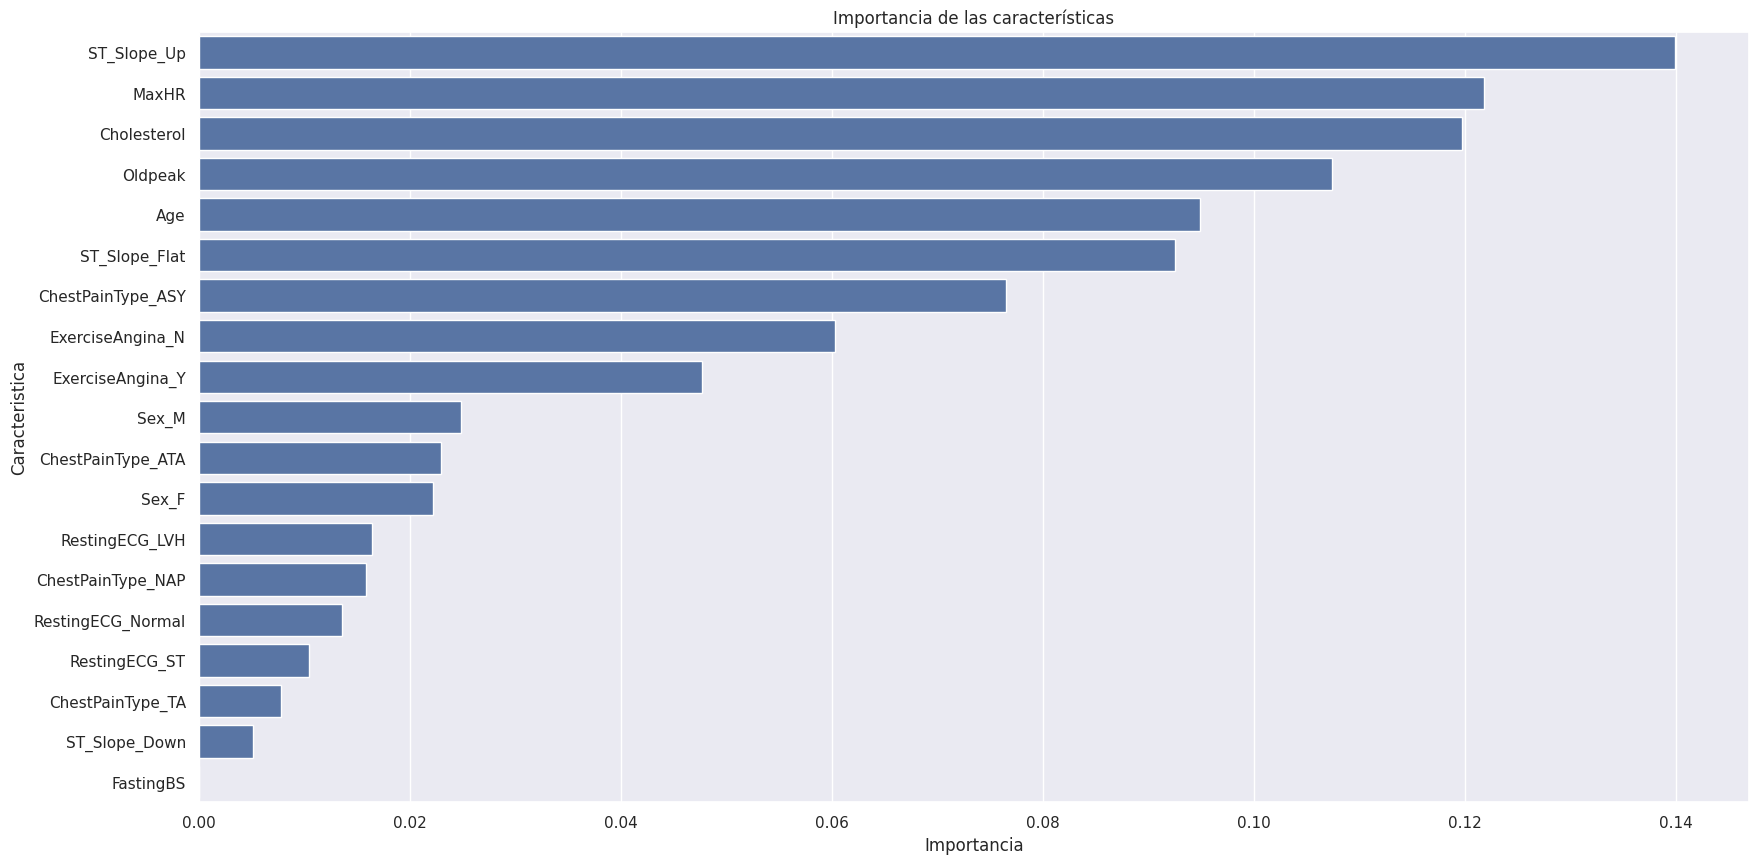

In [25]:
importancias = modelo.feature_importances_
caracteristicas = x_entrenamiento.columns

df_importancias = pd.DataFrame({'Caracteristica': caracteristicas, 'Importancia': importancias})
df_importancias = df_importancias.sort_values(by='Importancia', ascending=False)

sns.barplot(x='Importancia', y='Caracteristica', data=df_importancias)
plt.title("Importancia de las características")
plt.show()

**_Optimización de hiperparámetros_**

Antes de realizar la optimización de hiperparámetros, al mostrar la importancia de las características con respecto del modelo podemos observar el atributo FastingBS tiene una importancia de 0.00. Entonces una de las optimizaciones que se van a realizar va a ser eliminar dicho atributo.

Para continuar con la optimización se va a entrenar dos modelos, uno con gini y otro con entropy. Además, se va a hacer usando validación cruzada (por ejemplo n_splits = 5) y como lo ejecutaremos 5 veces, calcularemos la media de esas 5 ejecuciones.

In [26]:
drive.mount("/content/drive")

df_cardio_opt = pd.read_csv("/content/drive/My Drive/IABD/SAA/datasets/Tema 2/cardio.csv")

data_norm_opt = pd.get_dummies(df_cardio_opt)

data_norm_opt = outliersCambiarMedia(data_norm_opt)


data_norm_opt = data_norm_opt.drop("RestingBP", axis=1)
data_norm_opt_num = data_norm_opt.select_dtypes(include=[np.number])

scaler = preprocessing.MinMaxScaler()

data_norm_opt_num = data_norm_opt_num.drop(columns=["HeartDisease"], axis=1)

data_norm_opt[data_norm_opt_num.columns] = scaler.fit_transform(data_norm_opt_num)

x_df_cardio_opt = data_norm_opt.drop(["HeartDisease"], axis=1)

y_df_cardio_opt = data_norm_opt['HeartDisease']

x_entrenamiento, x_test, y_entrenamiento, y_test = train_test_split(x_df_cardio_opt, y_df_cardio_opt, random_state=1, test_size=0.2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Gini

In [27]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

df_opt = pd.DataFrame(data={}, columns=["max_depth", "media_prob_acertar"])

for i in range(1, 501, 10):
  modelo = RandomForestClassifier(n_estimators = i, random_state=1)
  puntuaciones = cross_val_score(modelo, x_entrenamiento, y_entrenamiento, cv=kf, scoring='accuracy')


  df_opt.loc[len(df_opt)] = [i, np.mean(puntuaciones)]

print("Criterio elegido Gini: ")
df_opt

Criterio elegido Gini: 


,max_depth,media_prob_acertar
0,1.0,0.769816
1,11.0,0.825673
2,21.0,0.820231
3,31.0,0.828404
4,41.0,0.837946
5,51.0,0.836595
6,61.0,0.831143
7,71.0,0.833865
8,81.0,0.836595
9,91.0,0.837955


#### Entropy

In [28]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

df_opt = pd.DataFrame(data={}, columns=["max_depth", "media_prob_acertar"])

for i in range(1, 501, 10):
  modelo1 = RandomForestClassifier(n_estimators = i,criterion='entropy', random_state=1)
  puntuaciones = cross_val_score(modelo1, x_entrenamiento, y_entrenamiento, cv=kf, scoring='accuracy')


  df_opt.loc[len(df_opt)] = [i, np.mean(puntuaciones)]

print("Criterio elegido Entropy: ")
df_opt

Criterio elegido Entropy: 


,max_depth,media_prob_acertar
0,1.0,0.771158
1,11.0,0.836548
2,21.0,0.835216
3,31.0,0.835206
4,41.0,0.842009
5,51.0,0.847461
6,61.0,0.847470
7,71.0,0.843388
8,81.0,0.843388
9,91.0,0.843379


Si vemos los resultados de ambos modelos, vemos que los mejores son de entropy. Además, en ambos modelos a partir del n_estimators 50 empiezan a estancarse los resultados e incluso puede ser que en número elevados esté empezando el sobre-ajuste. Los mejores hiperparámetros son entropy y n_estimators 51. Aunque la probabilidad se puede asemejar a los valores de gini, hay que tener en cuenta que el número de arboles es 51 con una probabilidad de 0.847 mientras que con gini se necesitan un total de 101 y alcanzaría un 0.842 haciendo que el modelo sea más complejo.

_Una vez obtenidos esos parámetros óptimos los aplicaremos al problema en cuestión y mostramos los resultados._

In [29]:
modelo = RandomForestClassifier(n_estimators = 51, random_state=1, criterion='entropy')
modelo.fit(x_entrenamiento, y_entrenamiento)

y_prediccion = modelo.predict(x_test)

print("La probabilidad de acertar es: ", accuracy_score(y_test, y_prediccion))

La probabilidad de acertar es:  0.8804347826086957
